In [164]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
import os

import cv2
from matplotlib import pyplot as plt
import numpy as np

from utils import load_image, toGrey, index_row_in_array, is_row_in_array, imshow_components

In [186]:
image1 = toGrey(load_image('test/world1/s1.jpg'))
# image2 = load_image('results/00976.jpg')
image2 = toGrey(load_image('results/45.9739.jpg'))
# image2 = toGrey(load_image('dump/2013-manu1.jpg'))
# image2 = toGrey(load_image('dump/image.jpg'))

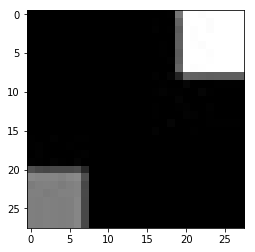

In [187]:
plt.imshow(image1.astype(np.uint8), cmap='gray', vmin=0)

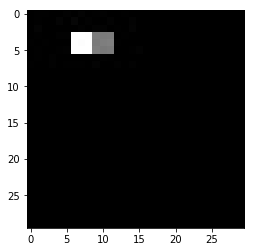

In [188]:
plt.imshow(image2.astype(np.uint8), cmap='gray', vmin=0)

In [189]:
y = image2.copy()
y_unique = np.unique(y)

In [184]:
y.shape

(30, 30)

1


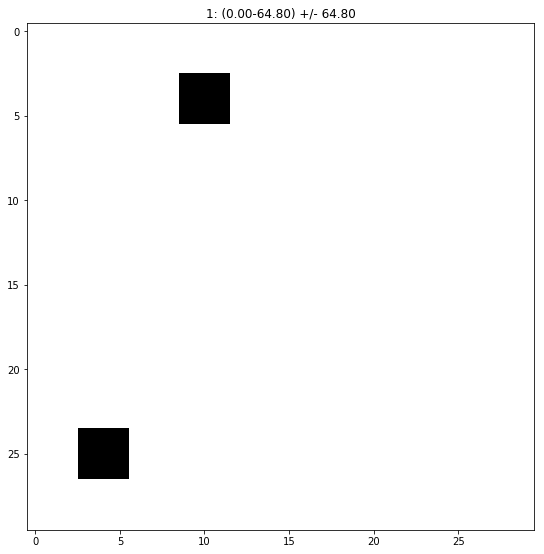

2


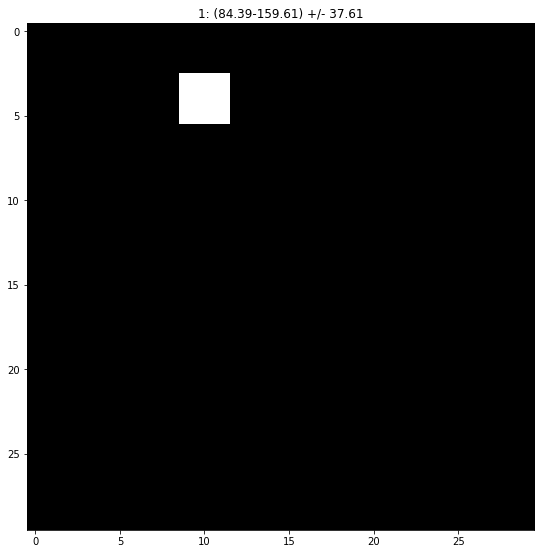

3


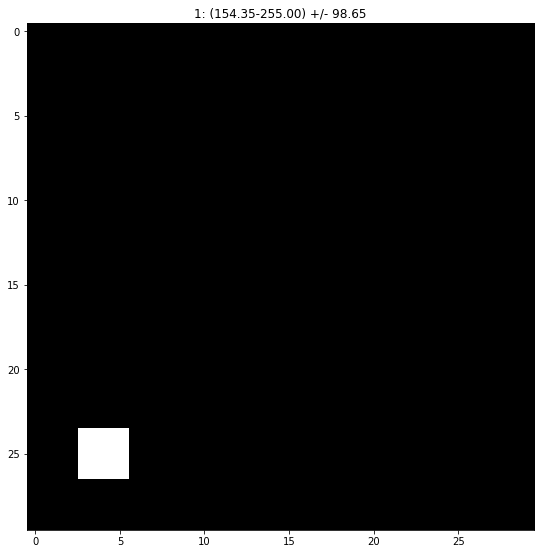

In [185]:
cls, cx = [], 0
last_b = -1
for i in y_unique:
    m = abs(i - y_unique).flatten()
    m = m.mean() - m.std()/2
    
    a = i - m;a = 0 if a < 0 else a
    b = i + m;b = 255 if b > 255 else b
    
    img = ((y >= a) & (y <= b)).astype(np.int8)

    display = False
    if len(cls) == 0:
        cls = np.array([img], dtype=np.int8)
        last_a, last_b = a, b
        display = True
        
    else:
        if a > (last_a + last_b)/2 and (not is_row_in_array(img, cls)):
            cls = np.concatenate((cls, [img]))
            last_a, last_b = a, b
            display = True
    
    if display:
        imgx = img.copy()
        cx+=1
        
        fig=plt.figure(figsize=(20, 20))
        w, h, rows, columns = 10, 10, 1, 2
        
        ret, labels = cv2.connectedComponents(img)
#         labeled_img = imshow_components(labels)
        
        li = [0, img]#, labeled_img]
        
        print(len(cls))
        for k in range(1, columns*rows):
            ax = fig.add_subplot(rows, columns, k)
            ax.set_title('{}: ({:.2f}-{:.2f}) +/- {:.2f}'.format(np.amax(labels), a, b, m))
            
            if k == 2:
                img1 = li[k]
                plt.imshow(li[k])
                
            if k == 1:
                img1 = np.zeros(tuple(list(img.shape)+[3]))
                for i in range(3):
                    img1[:,:,i] = 255*img
                plt.imshow(li[k], cmap='gray', vmin=0)
                
                cv2.imwrite('dump/{}-{}.png'.format(len(cls), k), img1)
        plt.show()
          
    
#     if cx == 3: break

In [172]:
np.amax(labels)

313

In [84]:
label = 1
pos = np.where(labels == label)
ar1, ar2 = pos

x1, x2 = min(ar1), max(ar1)+1
y1, y2 = min(ar2), max(ar2)+1

img_objx = imgx.copy()
img_objx[np.where(labels != label)] = 0
img_objx[np.where(labels == label)] = 1
img_objx = img_objx[x1:x2, y1:y2]

In [85]:
img_2x = img_objx.copy()

In [86]:
plt.imshow(img_1x, cmap='gray', vmin=0, vmax=1)

NameError: name 'img_1x' is not defined

In [87]:
img_1x.shape

NameError: name 'img_1x' is not defined

In [ ]:
plt.imshow(img_2x, cmap='gray', vmin=0, vmax=1)

In [ ]:
img_2x.shape

In [ ]:
c11, c12 = img_1x.shape
c21, c22 = img_2x.shape

r = c21 if c21 < c11 else c11
c = c22 if c22 < c12 else c12

img_1 = cv2.resize(img_1x.astype(np.uint8), (c, r), interpolation = cv2.INTER_AREA).astype(np.int8)
img_2 = cv2.resize(img_2x.astype(np.uint8), (c, r), interpolation = cv2.INTER_AREA).astype(np.int8)
(r, c), img_1.dtype

In [ ]:
plt.imshow(img_1, cmap='gray', vmin=0, vmax=1)

In [ ]:
plt.imshow(img_2, cmap='gray', vmin=0, vmax=1)

In [ ]:
img_1.shape, img_2.shape

In [ ]:
img_1a, img_1b = np.where(img_1 == 1)
img_1a = int(img_1a.mean())
img_1b = int(img_1b.mean())

img_1.shape, img_1a, img_1b

In [ ]:
img_2a, img_2b = np.where(img_2 == 1)
img_2a = int(img_2a.mean())
img_2b = int(img_2b.mean())

img_2.shape, img_2a, img_2b

In [ ]:
d, f = img_1.shape
g, h = img_2.shape

if img_1a <= img_2a:
    img_1x1 = img_2a - img_1a
    img_1x2 = img_1x1 + d
    
    img_2x1, img_2x2 = 0, g
    
else:
    img_2x1 = img_1a - img_2a
    img_2x2 = img_2x1 + g
    
    img_1x1, img_1x2 = 0, d
    

if img_1b <= img_2b:
    img_1y1 = img_2b - img_1b
    img_1y2 = img_1y1 + f
    
    img_2y1, img_2y2 = 0, h
    
else:
    img_2y1 = img_1b - img_2b
    img_2y2 = img_2y1 + h
    
    img_1y1, img_1y2 = 0, f
    
r = max((img_1x2, img_2x2))
c = max((img_1y2, img_2y2))

img_1x1,img_1x2, img_1y1,img_1y2, '=>', img_2x1, img_2x2, img_2y1, img_2y2


In [ ]:
img_n1

In [ ]:
img_n1 = np.zeros((r, c), dtype=np.int8)
img_n1[img_1x1:img_1x2, img_1y1:img_1y2] = img_1
plt.imshow(img_n1, cmap='gray', vmin=0, vmax=1)

In [ ]:
img_n2 = np.zeros((r, c), dtype=np.int8)
img_n2[img_2x1:img_2x2, img_2y1:img_2y2] = img_2
plt.imshow(img_n2, cmap='gray', vmin=0, vmax=1)

In [ ]:
img_b = img_n1.copy()
img_b[img_n2 == 0] = 0
plt.imshow(img_b, cmap='gray', vmin=0, vmax=1)

In [ ]:
np.where(img_n2 == 0)
np.where(img)

In [ ]:
m = 255 if np.amax(img_n1) > 1 or np.amax(img_n2) > 1 else 1

z1 = (m - abs(img_b - img_n2).mean()) / m
z2 = (m - abs(img_b - img_n1).mean()) / m
z3 = (m - abs(img_n2 - img_n1).mean()) / m

z1, z2, (z1 + z3 + z3) / 3

In [ ]:
plt.imshow(cv2.absdiff(img_b, img_n2), cmap='gray', vmin=0, vmax=1)

In [ ]:
(0.9603040540540541, 0.6587510993843448, 0.8095275767191994)

In [ ]:
(0.9453125, 0.6539179104477613, 0.7996152052238806)

In [ ]:
0.8115384615384615 * (1 - 0.2459016393442623)

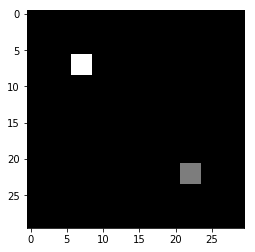

In [65]:
import numpy as np
from random import randint

w, h, g = 30, 30, (3, 3)

nh, nw = h/g[0], w/g[1]
nh, nw = list(map(int, [nh, nw]))

s, t = randint(0, nh-1), randint(0, nw-1)

s = s*g[0], s*g[1]
t = t*g[0], t*g[1]

s = list(map(int, s))
t = list(map(int, t))

gw = np.zeros((h, w), dtype=np.uint8)
gw[s[0]: s[0]+g[0], s[1]:s[1] + g[1]] = 125
gw[t[0]: t[0]+g[0], t[1]:t[1] + g[1]] = 255

plt.imshow(gw, cmap='gray', vmin=0, vmax=255)